In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [3]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/csv/CMG.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [4]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.4 MB/s eta 0:00:00


In [5]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12886.514, Time=1.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12910.321, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12881.520, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12881.922, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12908.621, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12883.367, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12883.388, Time=0.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12885.374, Time=2.55 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12879.678, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=12881.534, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12881.547, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12880.088, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=12883.540, Time=0.70 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 7.311 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [6]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [7]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[29333.3397766  29334.68658461 29334.93371636 29334.97906366
 29334.98738463 29334.98891148 29334.98919165 29334.98924306
 29334.9892525  29334.98925423 29334.98925454 29334.9892546
 29334.98925461 29334.98925462 29334.98925462 29334.98925462
 29334.98925462 29334.98925462 29334.98925462 29334.98925462
 29334.98925462 29334.98925462 29334.98925462 29334.98925462
 29334.98925462 29334.98925462 29334.98925462 29334.98925462
 29334.98925462 29334.98925462]


In [11]:
# 7. Tính RMSE, MSE, MAPE
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

valid_mse = mean_squared_error(y_val, y_pred_val)
test_mse = mean_squared_error(y_test, y_pred)

valid_rmse = np.sqrt(valid_mse)
test_rmse = np.sqrt(test_mse)

valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)*100
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 11495.432630576508
Testing RMSE: 18200.608401436242
Validation MAE: 11357.471322128373
Testing MAE: 15589.323153757658
Validation MAPE: 27.76703917866686
Testing MAPE: 31.266771068712824


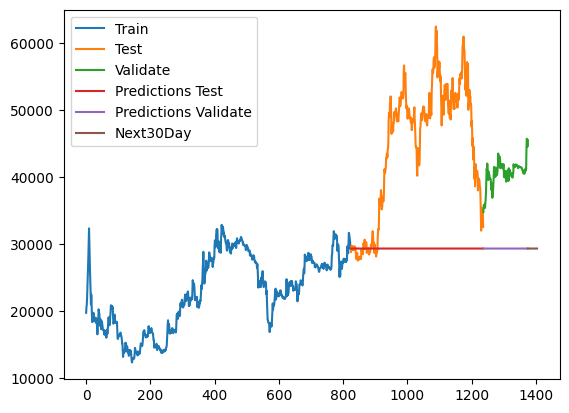

In [9]:
# 8.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Validate', 'Predictions Test', 'Predictions Validate','Next30Day'])
plt.show()

In [10]:
test_data.index

RangeIndex(start=825, stop=1237, step=1)